In this practical assignment you will learn how to work with reinforcement learning. You will be provided with an environment which generates rewards. It is your goal to implement a Tabular q-learning class which is able to accumulate reward after training.

Your code will be evaluated on clarity, conciseness and efficiency. Document your code. The resulting notebook including the required outputs should be converted to pdf and uploaded to Blackboard. Comments can be added in the notebook using markdown cells. Note that for code development you may want to use the PyCharm IDE, which facilitates debugging.

### Assignment 1

Below we provide a class Foo, which is an environment with which an agent can interact. Use a markdown cell to explain how the environment generates observations and responds to actions.

In [1]:
import numpy as np

class Foo(object):
    """
    Very simple environment for testing fully observed models. The actor gets a reward when it correctly decides
    on the ground truth. Ground truth 0/1 determines probabilistically the number of 0s or 1s on the output
    """

    def __init__(self, n, p = 0.8):
        """

        Args:
            n: number of inputs
            p: probability of emitting the right sensation at the input
        """

        super(Foo, self).__init__()

        self.ninput = n
        self.p = p
        self.noutput = 2

        self.reset()

    def reset(self):

        self.state = np.random.randint(0, 2)

        p = np.array([1 - self.p, self.p])

        if self.state == 0:
            p = 1 - p

        obs = np.random.choice(2, [1, self.ninput], True, p)

        return obs.astype(np.float32)

    def step(self, action):

        # reward is +1 or -1
        reward = 2 * int(action == self.state) - 1

        obs = self.reset()
        done = True

        return obs, reward, done

    def get_ground_truth(self):
        """
        Returns: ground truth state of the environment
        """

        return self.state

    def set_ground_truth(self, ground_truth):
        """
        :param: ground_truth : sets ground truth state of the environment
        """

        self.state = ground_truth

#### Reward
Once a agent is gonna take a step it has to choose between a 0 or a 1 as an action given an observation. The foo object keeps track of a state(also a 0 or a 1, chosen randomly with equal probability) which it uses to generate the observation. When the step taken is equal to the action taken by de agent it recieves a +1 reward. If not it receives a -1 reward. Thus the quality of the agent is dependend on how well it guesses the responsible state from the observeration.

#### Observation
The observation is generated in reset(). It is represented as an array of n(fixed parameter) bits.  A fixed parameter p defines the probability of a single bit of this observation being equal to the state bit. So if p=.8 and self.state=1, we have a .8 probability of each bit being a 1 and .2 of being 0. 



### Assignment 2

Below we provide a default implementation of an agent which takes random actions and an experimental run which shows how an agent can interact with an environment. Run the random agent on the environment and plot the cumulative reward gained throughout the experiment.

In [2]:
###
# Random agent

class RandomAgent(object):
    """
    Agent which takes random actions
    """

    def __init__(self, ninput, noutput, **kwargs):

        # Number of input variables
        self.ninput = ninput

        # Number of actions
        self.noutput = noutput

    def act(self, obs):
        """"
        Perform random action.
        """

        return np.random.randint(self.noutput)
    
    def learn(self,obs,obs2,action,reward,done):
        """
        Nothing to do
        """
        pass

In [25]:

# number of iterations
niter = 10**3

###########
# Environment specification

env = Foo(2,0.8)

###########
# Agent specification

agent = RandomAgent(env.ninput, env.noutput)

###########
# train phase

rewards = np.zeros([niter, 1])

obs = env.reset()
reward = done = None

for i in xrange(niter):

    # Choose an action
    action = agent.act(obs)

    # Perform action and receive new observations and reward
    obs2, reward, done = env.step(action)

    # Store reward
    rewards[i] = reward
    
    # Tabular q learning
    agent.learn(obs,obs2,action,reward,done)
    
    obs = obs2

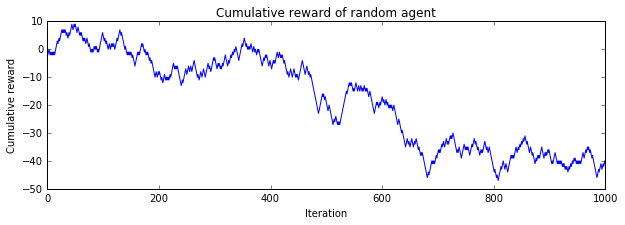

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot(rewards, title,show_type='cum'):
    #Calculate cumulative reward
    X = np.cumsum(rewards)
    #running average
    if show_type =='avg':
        X = X/(np.arange(X.shape[0]).astype(np.float32) + 1.)
        
    #plot it
    plt.figure(figsize=(10,3))
    plt.plot(X)
    plt.title(title)
    plt.ylabel("Cumulative reward")
    plt.xlabel("Iteration")
    plt.show()
plot(rewards, "Cumulative reward of random agent",'cum')


Since it's completely random the expected reward is 0. Since the probability for getting a reward of  +1 or -1 are equal.

### Assignment 3

Now implement a TabularQAgent which changes the policy using tabular q-learning. Reuse the above experimental run to show that the cumulative reward increases.

In [60]:
###
# Tabular Q agent

class TabularQAgent(object):
    """
    Agent which takes random actions
    """

    def __init__(self, ninput, noutput, eta, gamma,eps, **kwargs):

        # Number of input variables
        self.ninput = ninput

        # Number of actions
        self.noutput = noutput
        
        # learn rule parameters
        self.eta = eta
        self.gamma = gamma
        self.eps = eps
        
        # initialize Q-matrix with zeros, col numbers is the action, 
        # row number is integer representation of the observer bit string
        self.Q = np.zeros((2**self.ninput, self.noutput),dtype=np.float32)

    def act(self, obs):
        """"
        Perform random action.
        """
        # we have to come up with some sort of exploration-explotation 
        # algorithm in this case we use greedy-epsilon, but we make 
        # epsilon a bit smaller after each step
        if self.eps > np.random.ranf():
            # choose randomly:
            return np.random.randint(self.noutput)
        self.eps = np.maximum(0.001, .97 * self.eps)
        row = self._bits_2_int(obs)
        return np.argmax(self.Q[row,:])
    
    def learn(self,obs,obs2,action,reward,done):
        """
        Q learn
        """
        #
        current_state = self._bits_2_int(obs)
        new_state = self._bits_2_int(obs2)
        # future reward is actually completely useless since future state
        # is indepedent of current state
        future_reward = (np.argmax(self.Q[new_state,:]) -\
                         np.argmax(self.Q[current_state,:]))
        td_error = reward + self.gamma * future_reward 
        self.Q[current_state,action] = self.Q[current_state,action] + \
                                       self.eta * td_error

    def _bits_2_int(self,bits):
        """
        Used to translate observations to rows in the Q matrix, 
        bits are interperted in reverse order but works as long 
        as mapping is consitent
        :param: bits : array of bits with size ninput
        Returns: integer value of bits interperted as reverse bit string.
        """
        bits = bits[0]
        p = 1
        x = 0
        for i in range(len(bits)):
            x += bits[i] * p
            p = p * 2
        return int(x)
        

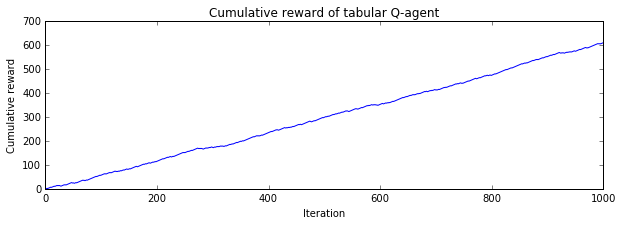

In [66]:
# number of iterations
niter = 10**3

def calc_and_plot(niter,p, title,eps=.15,plot_type='cum'):
    ###########
    # Environment specification

    env = Foo(2, p)

    ###########
    # Agent specification

    agent = TabularQAgent(env.ninput, env.noutput, .05, .5, eps)
    rewards = np.zeros([niter, 1])

    obs = env.reset()
    reward = done = None

    for i in xrange(niter):

        # Choose an action
        action = agent.act(obs)

        # Perform action and receive new observations and reward
        obs2, reward, done = env.step(action)

        # Store reward
        rewards[i] = reward

        # Tabular q learning
        agent.learn(obs,obs2,action,reward,done)

        obs = obs2
    plot(rewards, title,plot_type)
calc_and_plot(niter, 0.8,"Cumulative reward of tabular Q-agent")

Let's consider our 4 possible observation states:
- __00__, probability to get in this state is: $.5 p^2 + .5 (1-p)^2$ where we have $.5 p^2/(.5p^2 + .5(1-p)^2)$ to be right and $.5(1-p)^2/(.5 p^2 + .5(1-p)^2)$ to be wrong
- __01__, probability to get in this state is: $p(1-p)$ and .5 to be wrong and .5 to be right
- __10__, probability to get in this state is: $p(1-p)$ and .5 to be wrong and .5 to be right
- __11__, probability to get in this state is: $.5 p^2 + .5 (1-p)^2$ where we have $.5p^2/(.5 p^2 + .5(1-p)^2)$ to be right and $.5 (1-p)^2/(.5p^2 + .5 (1-p)^2)$ to be wrong
Assuming optimal policy

Our expected value thus is: $$(p^2 + (1-p)^2)* (.5p^2/(.5p^2 + .5(1-p)^2) - .5(1-p)^2/(.5 p^2 + .5(1-p)^2))  $$

For $p=0.8$ this comes down to $.68*(32/34 - 2/34) = 0.6$, so the policy seems to be almost optimal

### Assignment 4

Show how playing around with the observation probability <code>p</code> affects convergence.

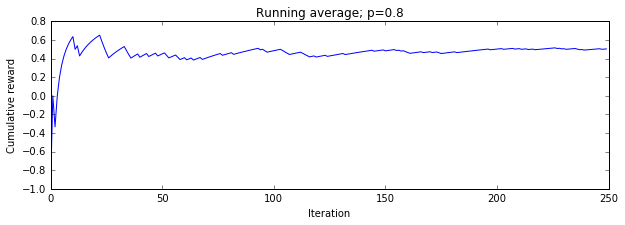

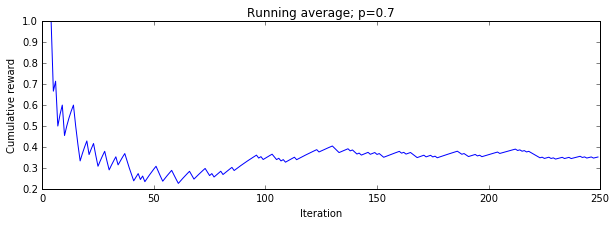

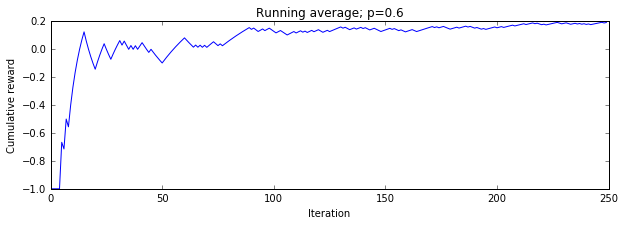

In [69]:
calc_and_plot(250, 0.8,"Running average; p=0.8",.3,'avg')
calc_and_plot(250, 0.7,"Running average; p=0.7",.3,'avg')
calc_and_plot(250, 0.6,"Running average; p=0.6",.3,'avg')

I am displaying the running average here to get a sense of how well we are converging. In general I would argue that it makes sense that a higher p would lead to higher convergence over n number of runs. Because with the same n we have a higher chance of seeing the optimal observetation for the given state for higer p. If p > 0.5.